In [359]:
from sympy import *
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [360]:
#define constants
g = 9.81

mass = .86 
l = .45
w = .45
h = .2

lc = 1 #lift coefficient 
dc = .23 #drag coefficient

In [361]:
mbody = .73 #rectangular prism
mrotor = .16 #rod
Ibodyx = 1/12 * mbody*(w**2 + h**2)
Ibodyy = 1/12 * mbody*(l**2 + h**2)
Ibodyz = 1/12 * mbody*(w**2 + l**2)
Irotorsx = 2*(1/12 * mrotor * (l/2)**2 + mrotor*(l/2)**2)
Irotorsy = 2*(1/12 * mrotor * (l/2)**2 + mrotor*(l/2)**2)
Irotorsz = 2*(1/12 * mrotor * (l/2)**2 + mrotor*(l/2)**2)
Itotalx = Ibodyx + 4*Irotorsx
Itotaly = Ibodyy + 4*Irotorsy
Itotalz = Ibodyz + 4*Irotorsz

In [362]:
def bforces(w1, w2, w3, w4):
    taux = h * lc * (-w2**2 + w4**2)
    tauy = h * lc * (-w1**2 + w3**2)
    tauz = h * lc * (w1**2 - w2**2 + w3**2 - w4**2)
    fz = lc *(w1**2 + w2**2 + w3**2 + w4**2)
    return taux, tauy, tauz, fz


In [363]:
#copy paste EoMs derived
def EoM(t, state, taux, tauy, tauz, fz):
    px, py, pz, vx, vy, vz, phi, theta, psi, wx, wy, wz = state
    
    pxd = vx*np.cos(psi)*np.cos(theta) + vy*(np.sin(phi)*np.sin(theta)*np.cos(psi) - np.sin(psi)*np.cos(phi)) + vz*(np.sin(phi)*np.sin(psi) + np.sin(theta)*np.cos(phi)*np.cos(psi))
    pyd = vx*np.sin(psi)*np.cos(theta) + vy*(np.sin(phi)*np.sin(psi)*np.sin(theta) + np.cos(phi)*np.cos(psi)) - vz*(np.sin(phi)*np.cos(psi) - np.sin(psi)*np.sin(theta)*np.cos(phi))
    pzd = -vx*np.sin(theta) + vy*np.sin(phi)*np.cos(theta) + vz*np.cos(phi)*np.cos(theta)
    vxd = -wy*vz + wz*vy + 9.81*np.sin(theta)
    vyd = wx*vz - wz*vx - 9.81*np.sin(phi)*np.cos(theta)
    vzd = fz/mass - wx*vy + wy*vx - 9.81*np.cos(phi)*np.cos(theta)
    phid = wx + wy*np.sin(phi)*np.tan(theta) + wz*np.cos(phi)*np.tan(theta)
    thetad = wy*np.cos(phi) - wz*np.sin(phi)
    psid = (wy*np.sin(phi) + wz*np.cos(phi))/np.cos(theta)
    wxd = (Itotaly*wy*wz - Itotalz*wy*wz + taux)/Itotalx
    wyd = (-Itotalx*wx*wz + Itotalz*wx*wz + tauy)/Itotaly
    wzd = (Itotalx*wx*wy - Itotaly*wx*wy + tauz)/Itotalz
    
    EOM = [pxd,pyd,pzd,vxd,vyd,vzd,phid,thetad,psid,wxd,wyd,wzd]

    return EOM

In [364]:
#caclulates intial conditions
r = 2 #circle radius
av = 0.5/2 #angular velocity
theta = -np.arctan(r*av**2/g)

T = mass*g / np.cos(theta) #fz
w = np.sqrt(T/(4*lc)) 


wx0 = av*np.sin(-theta)
wz0 = av*np.cos(-theta)
tauy = Itotalx*wx0*wz0 - Itotalz*wx0*wz0

In [365]:
#solve for w's using initial conditions
w1, w2, w3, w4 = symbols('w1, w2, w3, w4')
taux = Eq(h * lc * (-w2**2 + w4**2), 0)
tauy = Eq(h * lc * (-w1**2 + w3**2), tauy)
tauz = Eq(h * dc * (w1**2 - w2**2 + w3**2 - w4**2), 0)
fz = Eq(lc * (w1**2 + w2**2 + w3**2 + w4**2), T)

solved = solve((taux, tauy, tauz, fz), (w1, w2, w3, w4))

In [366]:
w1, w2, w3, w4 = solved[15] 
#solved returns 16 permutations of the w values, [15] is the solution with all positive values

In [367]:
px0 = 2
py0 = 0
pz0 = 1
vx0 = 0
vy0 = .5
vz0 = 0
phi0 = 0
theta0 = theta
psi0 = 0
omegax0 = wx0
omegay0 = 0
omegaz0 = wz0


t = (0, 60)

initial = [px0, py0, pz0, vx0, vy0, vz0, 
        phi0, theta0, psi0, omegax0, omegay0, omegaz0]

taux, tauy, tauz, fz = bforces(w1, w2, w3, w4)
forces = (taux, tauy, tauz, fz)
solved = solve_ivp(EoM, t, initial, max_step = 0.1, args = forces)


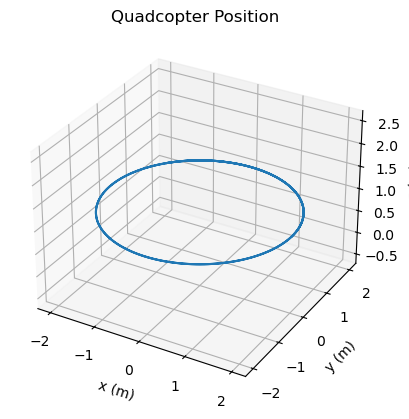

In [368]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(solved.y[0], solved.y[1], solved.y[2])
ax.axis('equal')

ax.set_title('Quadcopter Position')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('z (m)')
plt.show()

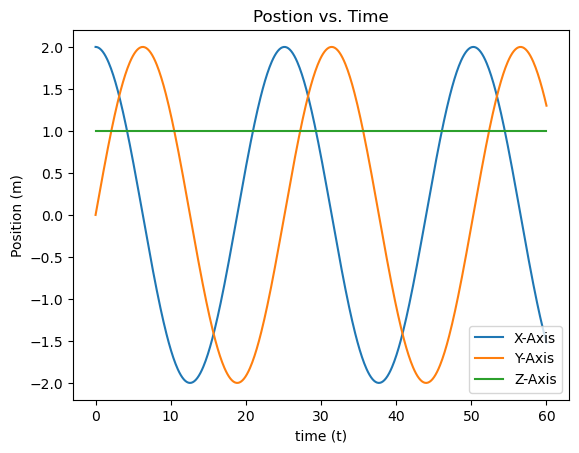

In [369]:
fig, ax = plt.subplots()
ax.plot(solved.t, solved.y[0], label = 'X-Axis')
ax.plot(solved.t, solved.y[1], label = 'Y-Axis')
ax.plot(solved.t, solved.y[2], label = 'Z-Axis')

ax.set_title('Postion vs. Time')
ax.set_xlabel('time (t)')
ax.set_ylabel('Position (m)')
ax.legend()
plt.show()

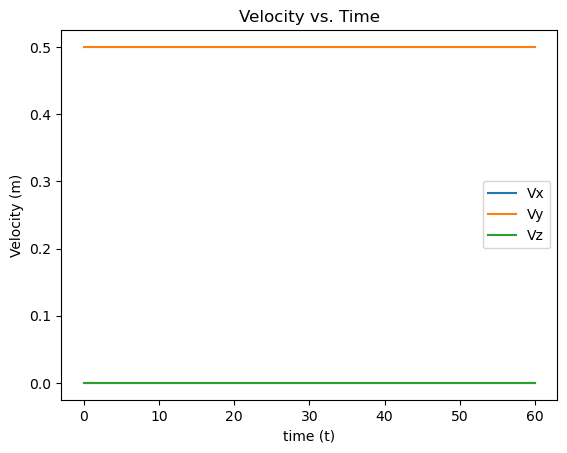

In [370]:
fig, ax = plt.subplots()
ax.plot(solved.t, solved.y[3], label = 'Vx')
ax.plot(solved.t, solved.y[4], label = 'Vy')
ax.plot(solved.t, solved.y[5], label = 'Vz')

ax.set_title('Velocity vs. Time')
ax.set_xlabel('time (t)')
ax.set_ylabel('Velocity (m)')
ax.legend()
plt.show()

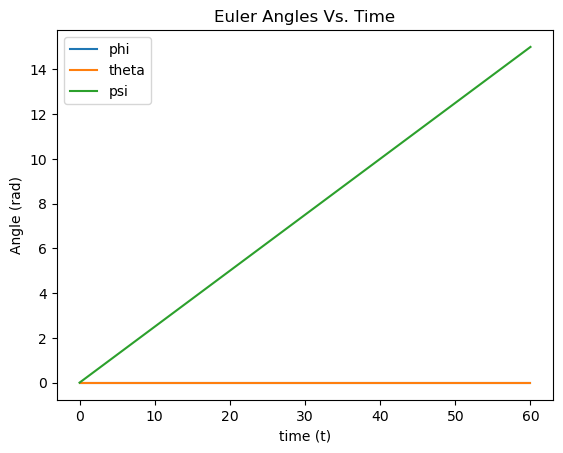

In [371]:
fig, ax = plt.subplots()
ax.plot(solved.t, solved.y[6], label = 'phi')
ax.plot(solved.t, solved.y[7], label = 'theta')
ax.plot(solved.t, solved.y[8], label = 'psi')

ax.set_title('Euler Angles Vs. Time')
ax.set_xlabel('time (t)')
ax.set_ylabel('Angle (rad)')
ax.legend()
plt.show()

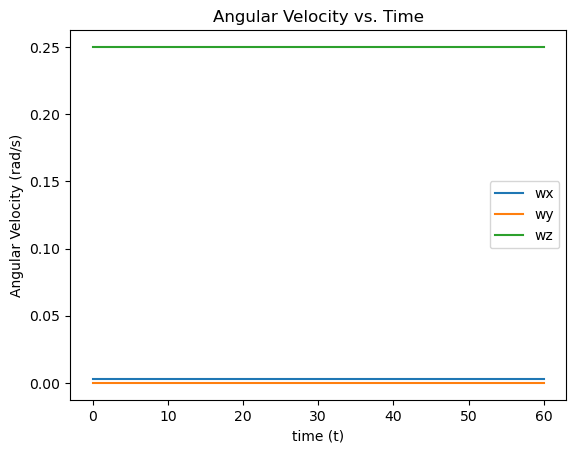

In [372]:
fig, ax = plt.subplots()
ax.plot(solved.t, solved.y[9], label = 'wx')
ax.plot(solved.t, solved.y[10], label = 'wy')
ax.plot(solved.t, solved.y[11], label = 'wz')

ax.set_title('Angular Velocity vs. Time')
ax.set_xlabel('time (t)')
ax.set_ylabel('Angular Velocity (rad/s)')
ax.legend()
plt.show()